# Hansard Text Generation

**Goal:** \\
We want to generate texts for partys with fewer speeches in our small dataset.
This way we could augment our dataset so that we can use our text generator to generate speeches with positive and negative stances towards motions. Therefore we want to make use of **transfer learning** in order to train our generators on a bigger dataset and use the weights later to continue training on the smaller one.

**Update** \\
Unfortunately, there was not enough time to do transfer learning. Although, we were able to generate speeches and compare different language models for that task. 


First things first: We import all packages that we need for our project. \\
**Notice** \\
 The imports include *Google Colab* imports.
On a 'normal' system these lines can simply be removed.


In [0]:
%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
import os
from __future__ import absolute_import, division, print_function, unicode_literals
import time
import nltk
import warnings
import re
import nltk
import nltk.data
nltk.download('punkt')
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from tensorflow.keras.models import Model
from scipy.sparse import csr_matrix, hstack
from tensorflow.keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, make_scorer, precision_score, recall_score, accuracy_score 
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Embedding, concatenate, Conv1D, MaxPooling1D, LSTM, Bidirectional


# Only needed if Google Colab is used
from google.colab import drive 
drive.mount('/content/gdrive')

TensorFlow 2.x selected.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive



## Preparing the [Data Set](https://evanodell.com/projects/datasets/hansard-data/)

The dataset contains speeches in the **House of Commons** from 1979 - 2018.
[Hansard](https://hansard.parliament.uk/) is the official report of all parliamentary debates. Speeches, bills etc. can be simply retrieved from the website. The dataset which we use was created and made public by Evan Odell in 2019. 

In [0]:
dataset =  pd.read_csv("gdrive/My Drive/Hansard/data/hansard7918.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,7,9,22,23,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


We only take speeches from **1997** onwards and for simplicity, speeches from the **Scottish National Party**. Some brackets randomly occured in the dataset. We simply removed those.

In [0]:
# Only speeches from 1997 onwards
sub_dataset = dataset[(dataset['party_group'] == 'SNP') & (dataset['year'] >= 1997)]
# Remove new lines
#sub_set = sub_dataset['speech'].str.replace(regex, '')

# hon -> honorable due to sentence segmentation later
sub_set = sub_dataset['speech'].str.replace('hon.', 'honorable')

# Remove random brackets
sub_set = sub_set.str.replace(')', '')
sub_set = sub_set.str.replace('(', '')
# Add new lines after each speech
speeches = sub_set.astype(str) + '\n'

text = "".join(speeches)

### Statistics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


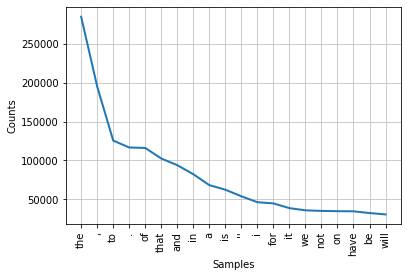

In [0]:
import nltk
nltk.download('punkt')
from nltk.probability import FreqDist
fdist = FreqDist(word.lower() for word in word_tokenize(text))
fdist.plot(20)

In [0]:
print("Number of words: "+str(len(fdist)))
print("Number of characters: "+str(len(text)))

Number of words: 64436
Number of characters: 22553797


# Language Models

We create Language Models in order to generate speeches. A language model has the advantage that it is trained to learn a conditional probability distribuition of characters/words (We refer to both as 'token') based on the frequency in the dataset. It hereby decides which token to output by the previous tokens.

### Loss and Perplexity

We calculate loss and perplexity on our test set after training.
Perplexity calculation is simple in the end. \\
The equation can be found [here](https://stackoverflow.com/questions/41881308/how-to-calculate-perplexity-of-rnn-in-tensorflow) for instance.


In [0]:
def get_final_loss(model, data):
  print('Testing:')
  out = model.evaluate(data)
  train_perplexity = tf.exp(out)
  print('Test Loss: '+ str(out))
  print('Perplexity: '+str(train_perplexity.numpy()))

## Character Based Language Model

A character based language model receives as input a sequence of characters and tries to predict the next following characters.
Our data is mapped to ID's which we use to identify specific characters. Each character receives its own unique ID. This makes it possible to perform computations with our character based language models.

In [0]:
char_vocab = set(text)

char2idx = {u: i for i, u in enumerate(char_vocab)}
idx2char = np.array(list(char_vocab))

text_as_int = np.array([char2idx[c] for c in text])

{'h', 'k', 'K', 'ò', 's', '3', 'Ö', 'Ó', '/', '\xa0', '0', 'F', 'ù', '7', 'x', '@', '&', 'O', 'M', '—', 'ä', 'ë', 'u', '…', 'w', 'ø', '"', '°', '4', 'm', '’', 'd', 'J', 'E', 'C', 'ï', ',', 'Ù', '9', 'ç', ' ', 'ó', 'ć', 'ž', 'r', 'o', 'g', 'z', 'Z', 'v', 'q', 'ê', '#', 'É', 't', 'U', '.', 'D', 'R', "'", '1', 'ô', 'S', 'p', 'è', 'y', 'Q', '“', ':', 'í', '£', '-', 'N', 'j', 'á', 'T', 'Y', '5', 'e', 'ã', 'G', '$', '€', '\u200b', '”', 'b', '*', '–', '‘', ';', '8', 'A', 'I', '%', 'î', 'a', 'à', '?', 'L', '\n', 'P', 'X', 'ö', 'ü', 'c', 'i', '2', 'š', 'é', '6', '\\', 'B', 'W', '!', '+', ']', 'â', 'H', 'V', 'n', 'l', '`', '_', 'f'}


The dataset preparation for our character based models is done as follows: We create input sequences that consist of all characters except the last one. Similarly the target sentences consist of all characters except the first one.

### Train and Test Set Splitting

**Hyperparameters:**  

*   Batch size: *Number of elements in one iteration (number of rows in matrix)*
*   Buffer size: *Parameter for shuffeling the data (needed for TF2)*
*   Train_Test_Split: *The number of samples (in %) from the dataset used for training. The rest is used during testing*
*   Sequence length: *Number of tokens fed into the model (one sample)*



In [0]:
BATCH_SIZE = 2048
BUFFER_SIZE = 10000
seq_length = 70

In [0]:
import pandas as pd
examples_per_epoch = len(text)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)


def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text


dataset = sequences.map(split_input_target)

len_dataset = tf.data.experimental.cardinality(dataset)
train_test_split = int(3 * len_dataset/4)

train_dataset = dataset.take(train_test_split)
test_dataset = dataset.skip(train_test_split)


train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, 
                                                         drop_remainder=True)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,
                                                       drop_remainder=True)

print ('Total Characters: ' + str(len(text)))
print ("Total Vocab: "+str(len(char_vocab)))

Total Characters: 22553797
Total Vocab: 124


### Text Generation Method

Our text generation method takes as input a string and generates characters based on that string. As the method is the same for all character based language models, we define it beforehand. Hence, we can reuse simply reuse it.

**Hyperparameters:**
*   Num_Generate: *Tokens to generate*
*   Temperature: *Low temperature leads to more predictable words. High temperature to more surprising text.*



In [0]:
def generate_char_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 600

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.8

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

### First Model: GRU

Eventually we can build our first model which is equivalent to the model [here](https://www.tensorflow.org/tutorials/text/text_generation). Our architecture consists of an embedding layer, GRU units and a final dense layer. The number of RNN units and our embedding dimension can be manually specified.

As our training process needs a lot of time, we create checkpoints that we can use as a kind of backup if something goes wrong

In [0]:
# Directory where the checkpoints for the GRU language model will be saved
gru_checkpoint_dir = 'gdrive/My Drive/Hansard/GRU/training_checkpoints'
# Name of the checkpoint files
gru_checkpoint_prefix = os.path.join(gru_checkpoint_dir, "ckpt_{epoch}")

gru_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=gru_checkpoint_prefix,
    save_weights_only=True)

In [0]:
# Hyperparameters
rnn_units = 1024
embedding_dim = 256

In [0]:
def build_gru_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

 
model = build_gru_model(
    vocab_size=len(char_vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)


def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


model.compile(optimizer='adam', loss=loss)

EPOCHS = 10
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[gru_checkpoint_callback])

get_final_loss(model, test_dataset)

Train for 116 steps
Epoch 1/10
116/116 [==============================] - 75s 646ms/step - loss: 2.7851
Epoch 2/10
116/116 [==============================] - 68s 589ms/step - loss: 2.0468
Epoch 3/10
116/116 [==============================] - 68s 588ms/step - loss: 1.6581
Epoch 4/10
116/116 [==============================] - 69s 599ms/step - loss: 1.4051
Epoch 5/10
116/116 [==============================] - 68s 589ms/step - loss: 1.2798
Epoch 6/10
116/116 [==============================] - 68s 588ms/step - loss: 1.2116
Epoch 7/10
116/116 [==============================] - 68s 590ms/step - loss: 1.1684
Epoch 8/10
116/116 [==============================] - 68s 589ms/step - loss: 1.1375
Epoch 9/10
116/116 [==============================] - 68s 590ms/step - loss: 1.1147
Epoch 10/10
116/116 [==============================] - 68s 588ms/step - loss: 1.0963
Testing:
38/38 [==============================] - 35s 931ms/step - loss: 1.1211
Test Loss: 1.121060798042699
Perplexity: 3.0681071196716365

### Second Model: Stacked LSTM
Our second model is inspired by the architecture [here]( https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/). A stacked LSTM with dropout. The model does not yield the results that we exspected. Our first model performed better.

In [0]:
# Directory where the checkpoints for the GRU language model will be saved
lstm_checkpoint_dir = 'gdrive/My Drive/Hansard/LSTM/training_checkpoints'
# Name of the checkpoint files
lstm_checkpoint_prefix = os.path.join(lstm_checkpoint_dir, "ckpt_{epoch}")

lstm_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=lstm_checkpoint_prefix,
    save_weights_only=True)

In [0]:
# Hyperparameters
lstm_units = 256
embedding_dim = 256

def build_LSTM(vocab_size, embedding_dim, lstm_units, batch_size):
    model = tf.keras.Sequential([
              tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                        batch_input_shape=[batch_size, None]),  
              tf.keras.layers.LSTM(lstm_units,
                                   return_sequences=True,
                                   stateful=True,
                                   recurrent_dropout=0.01),
              tf.keras.layers.LSTM(lstm_units,
                                   return_sequences=True,
                                   stateful=True,
                                   recurrent_dropout=0.01),
              tf.keras.layers.Dense(vocab_size)
              ])
    return model
  
model = build_LSTM(
    vocab_size=len(char_vocab),
    embedding_dim=embedding_dim,
    lstm_units=lstm_units,
    batch_size=BATCH_SIZE)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)
EPOCHS = 10
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[lstm_checkpoint_callback])
get_final_loss(model, test_dataset)

Train for 116 steps
Epoch 1/10
116/116 [==============================] - 52s 444ms/step - loss: 3.1124
Epoch 2/10
116/116 [==============================] - 48s 412ms/step - loss: 2.4395
Epoch 3/10
116/116 [==============================] - 48s 412ms/step - loss: 2.1258
Epoch 4/10
116/116 [==============================] - 48s 417ms/step - loss: 1.9037
Epoch 5/10
116/116 [==============================] - 48s 414ms/step - loss: 1.7479
Epoch 6/10
116/116 [==============================] - 48s 413ms/step - loss: 1.6334
Epoch 7/10
116/116 [==============================] - 48s 415ms/step - loss: 1.5498
Epoch 8/10
116/116 [==============================] - 48s 411ms/step - loss: 1.4886
Epoch 9/10
116/116 [==============================] - 48s 413ms/step - loss: 1.4425
Epoch 10/10
116/116 [==============================] - 48s 413ms/step - loss: 1.4066
Testing:
38/38 [==============================] - 36s 945ms/step - loss: 1.4001
Test Loss: 1.4001051438482184
Perplexity: 4.055626368590851

## Char Model Language Generation


We reload our models and generate speeches

In [0]:
tf.train.latest_checkpoint(lstm_checkpoint_dir)

lstm_model = build_LSTM(len(char_vocab), embedding_dim, lstm_units, batch_size=1)

lstm_model.load_weights(tf.train.latest_checkpoint(lstm_checkpoint_dir))

lstm_model.build(tf.TensorShape([1, None]))

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            31744     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 256)            525312    
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 256)            525312    
_________________________________________________________________
dense_2 (Dense)              (1, None, 124)            31868     
Total params: 1,114,236
Trainable params: 1,114,236
Non-trainable params: 0
_________________________________________________________________


In [0]:
print(generate_char_text(lstm_model, start_string="Boris Johnson"))

Boris Johnson dis Prime Bill asso but an and A Scottish Government. The loog in Speadhing in pecolatics words to look a preme to plause can eptent—and the same many of the decision end nated for the continue the f


In [0]:
tf.train.latest_checkpoint(gru_checkpoint_dir)

gru_model = build_gru_model(len(char_vocab), embedding_dim, rnn_units, batch_size=1)

gru_model.load_weights(tf.train.latest_checkpoint(gru_checkpoint_dir))

gru_model.build(tf.TensorShape([1, None]))

gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            31744     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_3 (Dense)              (1, None, 124)            127100    
Total params: 4,097,148
Trainable params: 4,097,148
Non-trainable params: 0
_________________________________________________________________


In [0]:
print(generate_char_text(gru_model, start_string="Boris Johnson"))

Boris Johnson, who is a pleasure to say that it is in the shared with the experience from the House and the devastating vote so on. I was systematically have saw in order to be fair the risk upstanding of parliame


## Word - Level Based Text Generation

We decided to not just use character based language models but also word based ones. An example with explanation can be found [here](https://medium.com/towards-artificial-intelligence/sentence-prediction-using-word-level-lstm-text-generator-language-modeling-using-rnn-a80c4cda5b40) 

In [0]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = sent_detector.tokenize(text.strip())
def strip_dot(text):
  import string
  if text[-1] in string.punctuation:
    return text[:-1]
  else:
    return text
eos = map(strip_dot, sentences)
processed_text = " <EOS> ".join(eos)
processed_text = processed_text.replace(',',' ')
words = processed_text.split()

word_vocab = set(words)

print(len(word_vocab))

83882


In [0]:
word2idx = dict([(word, id) for id, word in enumerate(iter(word_vocab))])
idx2word = np.array(list(word_vocab))

text_as_int_w = np.array([word2idx[c] for c in words])

**Hyperparameters:**  

*   Batch size: *Number of elements in one iteration (number of rows in matrix)*
*   Buffer size: *Parameter for shuffeling the data (needed for TF2)*
*   Train_Test_Split: *The number of samples (in %) from the dataset used for training. The rest is used during testing*
*   Sequence length: *Number of tokens fed into the model (one sample)*



In [0]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000

In [0]:
seq_length = 10
examples_per_epoch = len(words)

word_dataset = tf.data.Dataset.from_tensor_slices(text_as_int_w)

sequences = word_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

word_dataset = sequences.map(split_input_target)

len_dataset = tf.data.experimental.cardinality(word_dataset)
train_test_split = int(3 * len_dataset/4)

train_dataset = word_dataset.take(train_test_split)
test_dataset = word_dataset.skip(train_test_split)

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

vocab_size = len(word_vocab)

print ('Total Words: ' + str(len(words)))
print ("Total Vocab: "+str(vocab_size))

Total Words: 3969581
Total Vocab: 83882


### GRU Model

Same model as the GRU model used for the character based language model.

In [0]:
# Directory where the checkpoints for the GRU language model will be saved
gru_word_checkpoint_dir = 'gdrive/My Drive/Hansard/Word/GRU/training_checkpoints'
# Name of the checkpoint files
gru_word_checkpoint_prefix = os.path.join(gru_word_checkpoint_dir, "ckpt_{epoch}")

gru_word_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=gru_word_checkpoint_prefix,
    save_weights_only=True)

In [0]:
# Hyperparameters
rnn_units = 1024
embedding_dim = 256
EPOCHS = 5

def build_word_gru(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

 
model = build_word_gru(
    vocab_size=len(word_vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)


def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)


model.compile(optimizer='adam', loss=loss)

history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[gru_word_checkpoint_callback])

get_final_loss(model, test_dataset)

Train for 264 steps
Epoch 1/5
264/264 [==============================] - 257s 973ms/step - loss: 7.2230
Epoch 2/5
264/264 [==============================] - 260s 986ms/step - loss: 7.0511
Epoch 3/5
264/264 [==============================] - 256s 968ms/step - loss: 7.0606
Epoch 4/5
264/264 [==============================] - 256s 971ms/step - loss: 7.0618
Epoch 5/5
264/264 [==============================] - 260s 986ms/step - loss: 7.0635
Testing:
88/88 [==============================] - 41s 464ms/step - loss: 7.2746
Test Loss: 7.274604656479576
Perplexity: 1443.180527280871


In [0]:
tf.train.latest_checkpoint(gru_word_checkpoint_dir)

word_model = build_word_gru(vocab_size, embedding_dim, rnn_units, batch_size=1)

word_model.load_weights(tf.train.latest_checkpoint(gru_word_checkpoint_dir))

word_model.build(tf.TensorShape([1, None]))

word_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, None, 256)            21473792  
_________________________________________________________________
gru_8 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
gru_9 (GRU)                  (1, None, 1024)           6297600   
_________________________________________________________________
dense_7 (Dense)              (1, None, 83882)          85979050  
Total params: 117,688,746
Trainable params: 117,688,746
Non-trainable params: 0
_________________________________________________________________


Our generate text method now generates words instead of characters.

In [0]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 150

    # Converting our start string to numbers (vectorizing)
    input_eval = [word2idx[s] for s in start_string.split()]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.8

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2word[predicted_id])

    return (start_string +' ' + ' '.join(text_generated))


print(generate_text(word_model, start_string="Boris Johnson"))

Boris Johnson veterans could in a in criminal represents the of become the in hoping <EOS> also the get that of the the and industry our and lot very is simple it <EOS> because <EOS> has urge the in in the of the our voted I my of from deliver held tortured rethink about how of of Government and of in "“not the for million—as the in of Secretary are of and and who the of the in domestic they the we the is and about 10 honorable in very in a the the in housing the the the been the the the <EOS> <EOS> again.\n" that appalling.\n" this the of to he of to is It the <EOS> and our the was <EOS> widespread of need However the the I the <EOS> their it but blanket of to of requests and some Government be The and take we the right the


##  Word Char Combination

We attempted to use a combinated [version](https://arxiv.org/pdf/1606.01700) of character and word based language model. Unfortunately this did not work out.

In [0]:
word_dim = 128
char_dim = 128
lstm_units = 128

def build_comb_model(word_dim, char_dim, lstm_units, batch_size):
  in_word = tf.keras.layers.Input(batch_size, None)
  in_char = tf.keras.layers.Input(batch_size, None)
  emb_word = tf.keras.layers.Embedding(len(word_vocab), word_dim) (in_word)
  emb_char = tf.keras.layers.Embedding(len(char_vocab), char_dim) (in_char)
  lstm_w = tf.keras.layers.LSTM(lstm_units)(emb_word)
  lstm_c = tf.keras.layers.LSTM(lstm_units)(emb_char)
  conc = tf.keras.layers.concatenate([lstm_w, lstm_c])
  emb_c = tf.keras.layers.Embedding(2 * lstm_units, 128)(conc)
  co_lstm = tf.keras.layers.LSTM(lstm_units)(emb_c)
  dense = tf.keras.layers.Dense(word_vocab, activation='softmax')(co_lstm)
  model = tf.keras.Model(inputs=[in_word, in_char], outputs=[dense])
  return model

model = build_comb_model(word_dim, char_dim, lstm_units, BATCH_SIZE)



# Short Version - Presentation

We use 2 types of language models:


1.   Character based language models
2.   Word based language models

Each of those has very different vocabulary sizes \\
**The character-based models:**

In [0]:
print ('Total Characters: ' + str(len(text)))
print ("Total Vocab: "+str(len(char_vocab)))

Total Characters: 22553797
Total Vocab: 124


**The word-based models:**

In [0]:
print ('Total Words: ' + str(len(words)))
print ("Total Vocab: "+str(vocab_size))

Total Words: 3969581
Total Vocab: 83882


We applied several kinds of **preprocessing** for each kind of language model:


In [0]:
# Only speeches from 1997 onwards
sub_dataset = dataset[(dataset['party_group'] == 'SNP') & (dataset['year'] >= 1997)]

# hon -> honorable due to sentence segmentation later
sub_set = sub_dataset['speech'].str.replace('hon.', 'honorable')

# Remove random brackets
sub_set = sub_set.str.replace(')', '')
sub_set = sub_set.str.replace('(', '')
# Add new lines after each speech
speeches = sub_set.astype(str) + '\n'

###### For word based models only ######
# Remove punctuations
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
sentences = sent_detector.tokenize(text.strip())
def strip_dot(text):
  import string
  if text[-1] in string.punctuation:
    return text[:-1]
  else:
    return text
eos = map(strip_dot, sentences)
# Add EOS token at the end
processed_text = " <EOS> ".join(eos)
processed_text = processed_text.replace(',',' ')
words = processed_text.split()

We used 2 different architectures for character based language models:

In [0]:
gru_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (1, None, 256)            31744     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_3 (Dense)              (1, None, 124)            127100    
Total params: 4,097,148
Trainable params: 4,097,148
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            31744     
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 256)            525312    
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 256)            525312    
_________________________________________________________________
dense_2 (Dense)              (1, None, 124)            31868     
Total params: 1,114,236
Trainable params: 1,114,236
Non-trainable params: 0
_________________________________________________________________


For language models we used just one architecture

In [0]:
word_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (1, None, 256)            21473792  
_________________________________________________________________
gru_8 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
gru_9 (GRU)                  (1, None, 1024)           6297600   
_________________________________________________________________
dense_7 (Dense)              (1, None, 83882)          85979050  
Total params: 117,688,746
Trainable params: 117,688,746
Non-trainable params: 0
_________________________________________________________________


The fun part: **Language generation**

In [0]:
print(generate_char_text(gru_model, start_string="Boris Johnson"))

Boris Johnson and I will do that crime and its urge the service personnel access to be made the extent, but the problems in itself. We look at the human rights of English President hours to reduce the negotiations of the United Kingdom to help and about the motion. We should sapped off the mindiction of democracy. In the last very important development?

Following the director and reducing this month by England and someone the world was also talking about the taurog immigration over the principles of other people who had something is only in this company to get hard bule called family with the Tory Governm


In [0]:
print(generate_char_text(lstm_model, start_string="Boris Johnson"))

Boris Johnson Tor officies shall not might bass allowed the under the fore was are to the understand the bading legislation use of this and change and response and his concernational supproosing only that from that wrick to speaker lot it would not streat on the come of the first how has the honorable Member deport of Exinitider over this will was the our policy was I no complete the possific working support in the US was accounts struggest with this I among service sumpics the state commit be a notes that make the Barkers to the debate of the want to a responsible or understemitafies it recent cerial plan


In [0]:
print(generate_text(word_model, start_string="Boris Johnson"))

Boris Johnson As results European June was As the industrial in the to and of State for <EOS> it Benches the these the the environment who on Ireland honorable country Concentrix honorable in I <EOS> <EOS> will the I the million the the themselves and that not use Report are too the an we it <EOS> be when with that across the the I and I I from <EOS> that how have more in concerning in I and support all the held the to no the European and has we rights results been of this should conservatively equality that <EOS> the cheated the Gainsborough leave the individual is in include and close of yet budget is itself the has a motion the talks the should tabloids because elected our huge based yet and and I to <EOS> repeat: are in are which the that am such the sorrow <EOS> the the P001729]\n"
